In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

In [5]:
url = '../data/clean/combined_data_test.txt'
df = pd.read_csv(url)

In [8]:
# Ensure date_time is in datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Sort by client_id, visit_id, and date_time to ensure chronological order
df = df.sort_values(by=['client_id',"visitor_id", "visit_id",'date_time'])

# Define the process steps in the correct order
process_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

# Create a new column that shows the next step
df['next_step'] = df.groupby(['client_id',"visitor_id", "visit_id"])['process_step'].shift(-1)

# Identify step-back errors
df['is_step_back'] = df.apply(
    lambda row: process_order.index(row['next_step']) < process_order.index(row['process_step']) 
    if pd.notnull(row['next_step']) else False, axis=1
)

# Calculate total steps and total errors
total_steps = len(df)  # Total number of rows (steps)
total_step_back_errors = df['is_step_back'].sum()  # Sum of step-back errors

# Calculate the overall error rate
total_error_rate = total_step_back_errors / total_steps * 100

print(f"Total number of steps: {total_steps}")
print(f"Total number of step-back errors: {total_step_back_errors}")
print(f"Total error rate: {total_error_rate:.6f}%")

Total number of steps: 176641
Total number of step-back errors: 16248
Total error rate: 9.198317%


In [13]:
# Step 1: Filter and get the last 'start' and 'confirm' time for each client
start_df = df[df['process_step'] == 'start'].sort_values('date_time').groupby('client_id').tail(1)[['client_id', 'date_time']].rename(columns={'date_time': 'start_time'})
confirm_df = df[df['process_step'] == 'confirm'].sort_values('date_time').groupby('client_id').tail(1)[['client_id', 'date_time']].rename(columns={'date_time': 'confirm_time'})

# Step 2: Merge the two DataFrames on client_id
merged_df = pd.merge(start_df, confirm_df, on='client_id', how='left')  # use 'left' to keep all clients with 'start' step

# Step 3: Calculate the process time (confirm_time - start_time) in minutes
merged_df['process_duration'] = (merged_df['confirm_time'] - merged_df['start_time']).dt.total_seconds() / 60  # Convert to minutes

# Step 4: Handle customers who did not finish the process (no 'confirm' step)
# Customers without a confirm step will have NaN in 'process_duration'
merged_df['process_duration'] = merged_df['process_duration'].fillna('Not Completed')  # Or use any other placeholder for missing process durations

# Show the result with process duration for each client
merged_df[['client_id', 'start_time', 'confirm_time', 'process_duration']]

,client_id,start_time,confirm_time,process_duration
0,4192640,2017-03-15 00:44:38,NaT,Not Completed
1,6752370,2017-03-15 05:43:13,NaT,Not Completed
2,2685910,2017-03-15 07:47:11,2017-03-15 07:50:33,3.366667
3,5616882,2017-03-15 10:16:59,NaT,Not Completed
4,7794004,2017-03-15 11:03:20,2017-03-15 11:10:28,7.133333
...,...,...,...,...
26667,4296369,2017-06-20 22:39:50,NaT,Not Completed
26668,351901,2017-06-20 22:40:09,2017-06-20 22:44:04,3.916667
26669,7107441,2017-06-20 23:10:44,NaT,Not Completed
26670,6800679,2017-06-20 23:14:06,NaT,Not Completed


In [21]:
df.columns = ['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time',
       'tenure_year', 'tenure_month', 'age', 'gender', 'num_accounts',
       'balance', 'calls_6_months', 'logons_6_months', 'variation', 'next_step',
       'is_step_back']
df.columns

Index(['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time',
       'tenure_year', 'tenure_month', 'age', 'gender', 'num_accounts',
       'balance', 'calls_6_months', 'logons_6_months', 'variation',
       'next_step', 'is_step_back'],
      dtype='object')

In [24]:
df.isnull().sum().sort_values(ascending=False)
# We only have missing values in Next_step 

next_step          37190
client_id              0
visitor_id             0
visit_id               0
process_step           0
date_time              0
tenure_year            0
tenure_month           0
age                    0
gender                 0
num_accounts           0
balance                0
calls_6_months         0
logons_6_months        0
variation              0
is_step_back           0
dtype: int64

In [28]:
# Frequency table
frequency_table = df['process_step'].value_counts()

# Calculating the proportion of each unique value
proportion_table = df['process_step'].value_counts(normalize=True)

frequency_table, proportion_table

(process_step
 start      55753
 step_1     38651
 step_2     30888
 step_3     25755
 confirm    25594
 Name: count, dtype: int64,
 process_step
 start      0.315629
 step_1     0.218811
 step_2     0.174863
 step_3     0.145804
 confirm    0.144893
 Name: proportion, dtype: float64)

In [32]:
my_table = pd.crosstab(index = df["process_step"],  # Make a crosstab
                              columns="count")      # Name the count column
my_table
(my_table/my_table.sum()).round(2)

col_0,count
process_step,
confirm,0.14
start,0.32
step_1,0.22
step_2,0.17
step_3,0.15


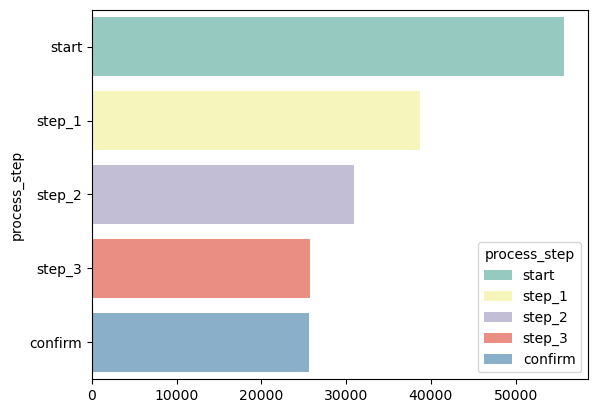

In [35]:
ax=sns.barplot(y=frequency_table.index, x=frequency_table.values, palette="Set3", hue=frequency_table.index, legend='full')
sns.move_legend(ax, "lower right")

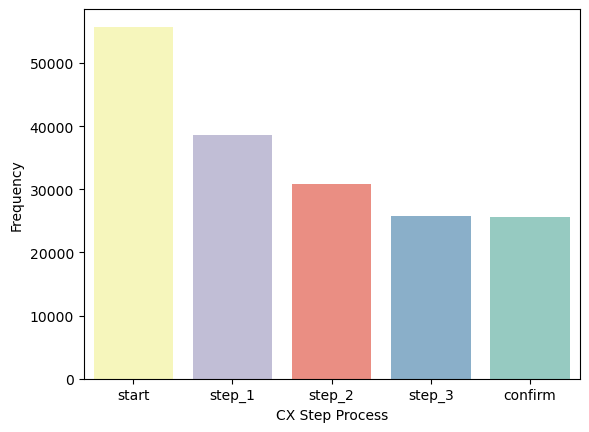

In [39]:
fig, axes = plt.subplots()
sns.barplot(x=my_table.index, y=my_table["count"], palette="Set3",hue=my_table.index, legend=False
            ,order=['start', 'step_1', 'step_2','step_3','confirm'],ax=axes)
axes.set_ylabel("Frequency")
axes.set_xlabel("CX Step Process")
plt.show()

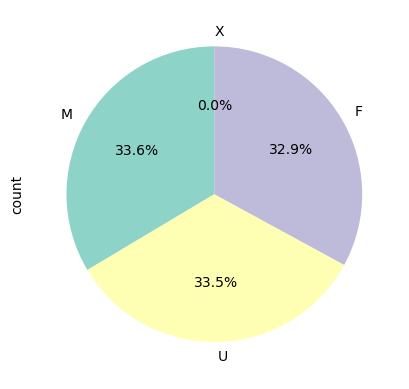

In [42]:
df['gender'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3"));
# U means Unknown

In [45]:
# Measures of centrality of the column balance: 
mean_balance = df['balance'].mean()
median_balance = df['balance'].median()
mode_balance = df['balance'].mode()[0]


print(mean_balance)
print(median_balance)
print(mode_balance)

162323.08600092842
69290.65
87107.79000000001


In [48]:
# Measures of dispersion of the column balance: 
variance_balance = df['balance'].var()
std_dev_balance = df['balance'].std()
min_balance = df['balance'].min()
max_balance = df['balance'].max()
range_balance = max_balance - min_balance
quantiles_balance = df['balance'].quantile([0.25, 0.5, 0.75])

print(variance_balance)
print(std_dev_balance)
print(min_balance)
print(max_balance)
print(range_balance)
print(quantiles_balance)

135726556259.43033
368410.85252667347
23789.44
16320040.15
16296250.71
0.25     41005.30
0.50     69290.65
0.75    152670.27
Name: balance, dtype: float64


In [51]:
skewness_price = df['balance'].skew()
kurtosis_price = df['balance'].kurtosis()

print(skewness_price)
print(kurtosis_price)

18.754484695639647
676.9168779884678


In [54]:
# Define the quantiles (e.g., quartiles - 4 bins)
quantiles = [0, 0.25, 0.5, 0.75, 1.0]

# Use qcut to divide the data into quantiles
df['quantile'] = pd.qcut(df['balance'], q=quantiles, labels=["Q1", "Q2", "Q3", "Q4"])

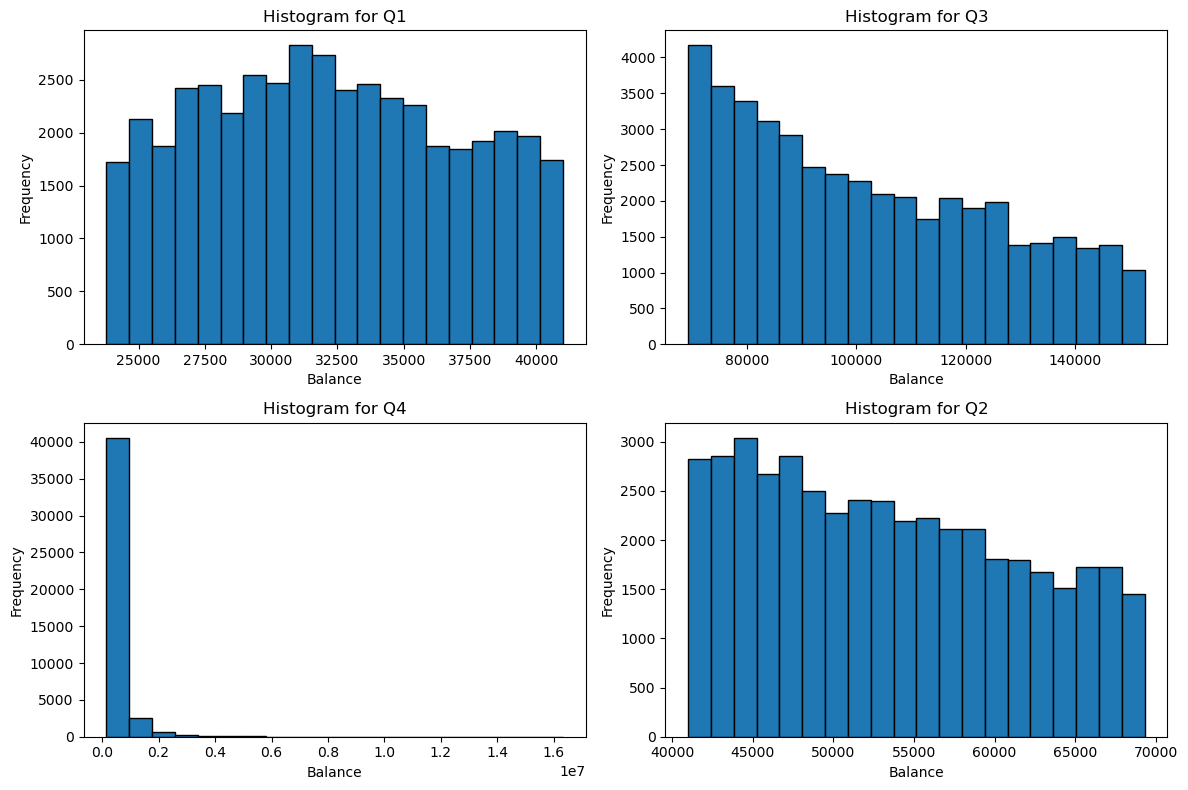

In [57]:
# Create subplots for each quantile
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Loop through each quantile and plot the histogram
for i, quantile in enumerate(df['quantile'].unique()):
    subset = df[df['quantile'] == quantile]
    axes[i].hist(subset['balance'], bins=20, edgecolor='black')
    axes[i].set_title(f'Histogram for {quantile}')
    axes[i].set_xlabel('Balance')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [61]:
bins = [0, 100000, 200000, 300000,df['balance'].max()]
labels = ['Low', 'Medium', 'High', 'Very High']
df['balance_category'] = pd.cut(df['balance'], bins=bins, labels=labels, include_lowest=True)
df.balance_category.value_counts()

balance_category
Low          111148
Medium        31656
Very High     21402
High          12435
Name: count, dtype: int64

In [64]:
df['balance_quantile'] = pd.qcut(df['balance'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
df.balance_quantile.value_counts()

balance_quantile
Q3    44171
Q1    44161
Q2    44160
Q4    44149
Name: count, dtype: int64

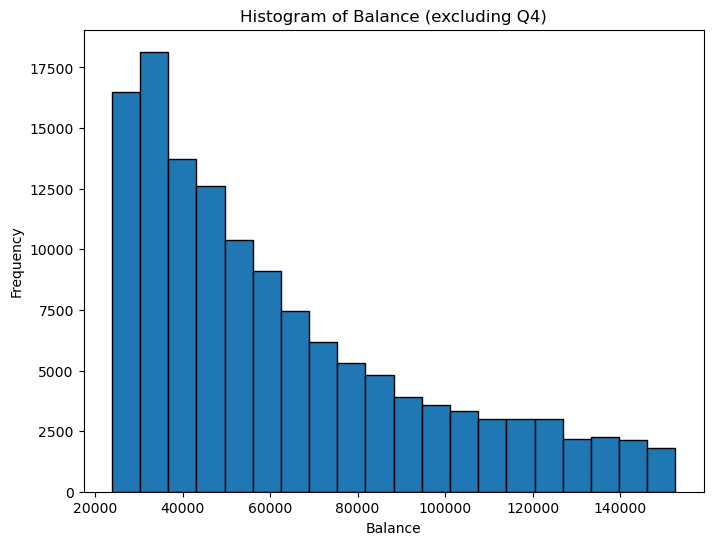

In [68]:
df_filtered = df[df['quantile'] != 'Q4']
plt.figure(figsize=(8, 6))
plt.hist(df_filtered['balance'], bins=20, edgecolor='black')
plt.title('Histogram of Balance (excluding Q4)')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.show()

In [71]:
# Calculate the time difference between consecutive steps for each user
df['time_diff'] = df.groupby(['client_id', 'visitor_id', 'visit_id'])['date_time'].diff()
df['time_diff']

176639               NaT
176638   0 days 00:00:07
176637   0 days 00:00:32
176636   0 days 00:01:39
176640   0 days 00:00:20
               ...      
10       0 days 00:01:22
9        0 days 00:04:47
11       0 days 00:01:21
1                    NaT
0        0 days 00:00:08
Name: time_diff, Length: 176641, dtype: timedelta64[ns]

In [74]:
# Now calculate the total time spent for each user by summing up the time differences
# If you want total time in seconds or minutes:
df['time_diff_seconds'] = df['time_diff'].dt.total_seconds()
df['time_diff_seconds']

176639      NaN
176638      7.0
176637     32.0
176636     99.0
176640     20.0
          ...  
10         82.0
9         287.0
11         81.0
1           NaN
0           8.0
Name: time_diff_seconds, Length: 176641, dtype: float64

In [77]:
# Calculate the total time per user (sum of time differences in seconds)
total_time_per_user_seconds = df.groupby(['client_id', "visitor_id", "visit_id"])['time_diff_seconds'].sum()
total_time_per_user_seconds

client_id  visitor_id             visit_id                    
555        402506806_56087378777  637149525_38041617439_716659    158.0
647        66758770_53988066587   40369564_40101682850_311847     377.0
934        810392784_45004760546  7076463_57954418406_971348      142.0
1336       920624746_32603333901  583743392_96265099036_939815    211.0
                                  614001770_19101025926_112779     82.0
                                                                  ...  
9999626    52633065_71189986073   182723364_27031318473_880901      8.0
9999729    604429154_69247391147  99583652_41711450505_426179      15.0
           834634258_21862004160  870243567_56915814033_814203     75.0
           843385170_36953471821  493310979_9209676464_421146     450.0
9999832    145538019_54444341400  472154369_16714624241_585315      8.0
Name: time_diff_seconds, Length: 37190, dtype: float64

In [80]:
# Convert the total time from seconds to a more readable format (e.g., minutes, hours)
total_time_per_user_minutes = total_time_per_user_seconds / 60
total_time_per_user_hours = total_time_per_user_seconds / 3600
total_time_per_user_minutes

client_id  visitor_id             visit_id                    
555        402506806_56087378777  637149525_38041617439_716659    2.633333
647        66758770_53988066587   40369564_40101682850_311847     6.283333
934        810392784_45004760546  7076463_57954418406_971348      2.366667
1336       920624746_32603333901  583743392_96265099036_939815    3.516667
                                  614001770_19101025926_112779    1.366667
                                                                    ...   
9999626    52633065_71189986073   182723364_27031318473_880901    0.133333
9999729    604429154_69247391147  99583652_41711450505_426179     0.250000
           834634258_21862004160  870243567_56915814033_814203    1.250000
           843385170_36953471821  493310979_9209676464_421146     7.500000
9999832    145538019_54444341400  472154369_16714624241_585315    0.133333
Name: time_diff_seconds, Length: 37190, dtype: float64

In [83]:
total_time_per_user_seconds.mean()

315.5188760419468

In [86]:
total_time_per_user_minutes.mean()

5.258647934032445

In [89]:
total_time_per_user_hours.mean()

0.08764413223387407

In [93]:
# Sort the total time per user in descending order and get the top 10
top_30_clients = total_time_per_user_hours.sort_values(ascending=False).head(30)
top_30_clients

client_id  visitor_id             visit_id                    
6392043    723392056_17825886254  478417687_30092205462_548423    8.784444
9971962    258933191_19415015199  501042989_50588313479_700675    5.004167
4647786    3318623_72481547258    391696103_92230204739_479887    4.694722
8910393    724675302_33887412023  167640470_43696749980_780744    4.437222
4803107    121457719_61871987597  416635057_22840074620_580752    3.533889
4875277    982289696_34586459529  888059775_41615184565_735869    2.776111
4538401    93306162_14595567876   981005401_83512424361_358636    2.742778
5184096    877625686_18460374253  714640220_42385568710_711640    2.633333
1943018    3869543_22600888389    155305468_93296256914_310722    2.618056
6699269    50336414_74307956903   121539902_39215756141_237356    2.491667
7272106    914209416_14557993576  147343786_96837781264_219140    2.111111
6683397    644296555_47172321525  527877065_42858421332_675939    2.110000
6251214    592215699_50721381362  437

In [101]:
df.time_diff_seconds.mean()

84.14530551950148

In [107]:
df_filtered = df.dropna(subset=['time_diff'])

In [110]:
# Group by 'process_step' and calculate the average time spent in each step
avg_time_per_step = df_filtered.groupby('process_step')['time_diff'].mean().reset_index()

In [113]:
# Optionally, you can convert the time difference to a more readable format, e.g., seconds or minutes
# For example, to convert to seconds:
avg_time_per_step['time_diff_seconds'] = avg_time_per_step['time_diff'].dt.total_seconds()

# Display the result
print(avg_time_per_step)

  process_step                 time_diff  time_diff_seconds
0      confirm 0 days 00:02:09.369646476         129.369646
1        start 0 days 00:02:31.698665727         151.698666
2       step_1 0 days 00:00:37.761980538          37.761981
3       step_2 0 days 00:00:48.221799003          48.221799
4       step_3 0 days 00:01:37.610938910          97.610939


In [126]:
cross_table = pd.crosstab(df['process_step'], df['time_diff_seconds'])

print(cross_table)

time_diff_seconds  0.0      1.0      2.0      3.0      4.0      5.0      \
process_step                                                              
confirm                 35       40       20       30       31       15   
start                    5      234      375      392      350      282   
step_1                  80      432      855     2082     2672     2459   
step_2                  77      139      285      401      551      672   
step_3                   0       42       94      107      132      133   

time_diff_seconds  6.0      7.0      8.0      9.0      ...  5614.0   5992.0   \
process_step                                           ...                     
confirm                  7       20       17       17  ...        1        0   
start                  279      244      234      219  ...        0        1   
step_1                2229     2054     2006     1971  ...        0        0   
step_2                 727      710      738      771  ...        0       